In [13]:
include("../LiPoSID.jl")

using LinearAlgebra
function ⊗(A::AbstractMatrix, B::AbstractMatrix)
    return kron(A,B)
end

function LME_operator_symbolic(H, J)
    
    Id = I(2)   
    U = -im*(Id ⊗ H - transpose(H) ⊗ Id)
    D = sum( 2*transpose(j')⊗j-Id⊗(j'*j) - transpose(j)*transpose(j')⊗Id for j in J )/2 
    
    Lᴸᴹᴱ = U + D
    
    return Lᴸᴹᴱ
end

using SymPy
@syms s

using DynamicPolynomials

function Transfer_Function(A, b)
    inv(I(4)*s - A)*b
end

bₓ = [1, 0, 0, 1]

function SumCoeffs2(poly)
    p = expand(numerator(poly))
    degrees = range(0,convert(Int32,SymPy.degree(p, s)))
    obj = sum([p.coeff(s^i)^2 for i in degrees])
    return obj
end

function sympy_to_dynamicpoly(sympy_expr) #::Sym
    # Extract variables from the SymPy expression
    vars = free_symbols(sympy_expr)

    # Convert SymPy variables to string and then to Symbol
    var_symbols = [Symbol(string(v)) for v in vars]

    # Create DynamicPolynomials variables using @polyvar macro
    @eval begin
        @polyvar $(var_symbols...)
    end

    # Map SymPy variables to DynamicPolynomials variables
    var_map = Dict(vars[i] => eval(var_symbols[i]) for i in 1:length(vars))

    # Substitute using subs and convert to DynamicPolynomial
    dynamic_poly_expr = SymPy.subs(sympy_expr, var_map)
    dynamic_poly = eval(Meta.parse(string(dynamic_poly_expr)))
    return dynamic_poly
end

function TF_objective(Aˢʸᵐᵇ, Aˢⁱᵈ, b)

    Gˢʸᵐᵇ = Transfer_Function(Aˢʸᵐᵇ, b)[1:3]

    Gˢⁱᵈ = Transfer_Function(Aˢⁱᵈ, b)[1:3]

    ΔG = together.(Gˢʸᵐᵇ - Gˢⁱᵈ)

    polys = numerator.(ΔG)

    obj = sum(SumCoeffs2.(polys))

    objective = sympy_to_dynamicpoly(obj)

    return objective

end

using Plots;



In [14]:
ω = symbols("ω", real=true)
γ = symbols("γ", real=true)

Hᴸᴹᴱ = [ ω        0
         0        0   ]


Jᴸᴹᴱ = [ 0     γ
         0     0. + 0im  ]

Lᴸᴹᴱ = LME_operator_symbolic(Hᴸᴹᴱ, [Jᴸᴹᴱ])

M =   [ 0  0    1  1
        1  -im  0  0 
        1  im   0  0
        0  0   -1  1 ]/2

Aᴸᴹᴱ = real.(inv(M) * Lᴸᴹᴱ * M)



4×4 Matrix{Sym{PyCall.PyObject}}:
 -0.5*γ^2     1.0⋅ω         0        0
   -1.0⋅ω  -0.5*γ^2         0        0
        0         0  -1.0*γ^2  1.0*γ^2
        0         0         0        0

In [15]:
γₜₛₜ = .2^2 #(4π/2)
ωₜₛₜ = 25

Aˢⁱᵈ = [  0    -ωₜₛₜ   0      0 
          ωₜₛₜ -γₜₛₜ   0      0
          0     0     -γₜₛₜ   γₜₛₜ
          0     0      0      0    ]

objective = TF_objective(Aᴸᴹᴱ, Aˢⁱᵈ, bₓ)

#best_solution, best_method = LiPoSID.sos_min_newton(objective) 



39.0625γ⁸ + 6.25γ⁶ + 312.5γ⁴ω² - 194530.00000000003γ⁴ + 25.0γ²ω² + 625.0ω⁴ + 2.0γ²ω - 15625.08γ² - 781248.9984ω² + 50.0ω + 2.441412500016e8

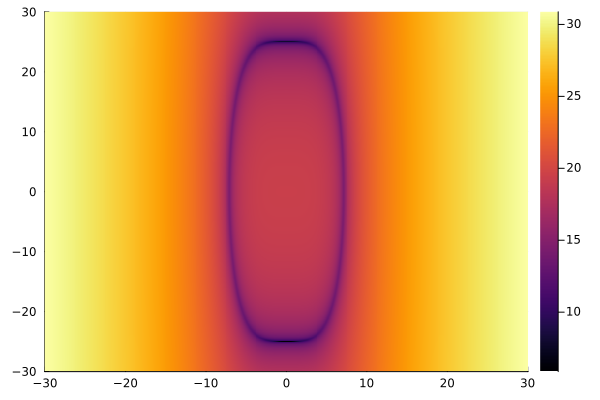

In [20]:
function f(γ_val, ω_val)
    return objective(variables(objective)[1] => γ_val, variables(objective)[2] => ω_val)
end

w = range(-30, 30, length=1000)
#g = range(-3*γᶠ, 3*γᶠ, length=500)
g = range(-30, 30, length=500)
z = @. f(g', w)

heatmap(g, w, log.(z))

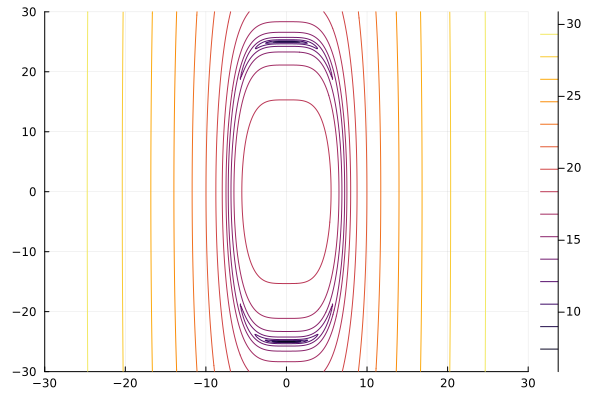

In [21]:
contour(g, w, log.(z))

In [22]:
best_solution, best_method = LiPoSID.sos_min_newton(objective) 

*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: SLOW_PROGRESS
solution status: FEASIBLE_POINT
optimum = 0.20006359990026795
Global optimality certified with relative optimality gap 0.000005%!
No higher TS step of the TSSOS hierarchy!
*********************************** TSSOS ***********************************
Version 1.0.0, developed by Jie Wang, 2020--2023
TSSOS is launching...
termination status: SLOW_PROGRESS
solution status: FEASIBLE_POINT
optimum = 0.20006312642441468
Global optimality certified with relative optimality gap 0.000049%!
No higher TS step of the TSSOS hierarchy!
val_p = [0.20006367564201355, 0.20006361603736877]


(PolyVar{true}[γ, ω] => [0.1789152275903355, -24.999982067419822], "scaled_tssos")